In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('dataweatherstation.csv',parse_dates=['tanggal'])
display(df.shape, df.head())

(49308, 8)

,id,tanggal,hujan,kelembabpan,tekanan_udara,temperature,tingkat_cahaya,keterangan
0,9470,2023-03-09 01:01:00,0,98,93657.02,23,0,cerah
1,9469,2023-03-09 01:01:00,0,98,93656.45,23,0,cerah
2,9490,2023-03-09 01:02:00,0,98,93656.99,23,0,cerah
3,9489,2023-03-09 01:02:00,0,98,93656.55,23,0,cerah
4,9488,2023-03-09 01:02:00,0,98,93657.02,23,0,cerah


In [3]:
def prep(df):
    # Cleaning Data Malam yang memiliki cahaya
    df.drop(df[(df.tanggal.dt.hour>18)  &  (df.tingkat_cahaya>100)].index,inplace=True)

    # Drop Anomaly Data
    df.drop(df[(df['hujan']>5) & (df['tingkat_cahaya']>30)].index,inplace=True)

    # Balancing Data
    df.drop([i for i in df[(df['hujan'] == 0) &( df['tingkat_cahaya'] == 0)].index if (i%2==0) and (i%3==0)],inplace=True)
    df.drop(df[df['hujan']==0].sample(32000).index,inplace=True)
    df.reset_index()
        
    df.drop(['tekanan_udara'],axis=1,inplace=True)

In [4]:
# df.drop(['tekanan_udara'],axis=1,inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49308 entries, 0 to 49307
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              49308 non-null  int64         
 1   tanggal         49308 non-null  datetime64[ns]
 2   hujan           49308 non-null  int64         
 3   kelembabpan     49308 non-null  int64         
 4   tekanan_udara   49308 non-null  float64       
 5   temperature     49308 non-null  int64         
 6   tingkat_cahaya  49308 non-null  int64         
 7   keterangan      49308 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 3.0+ MB


In [17]:
df.describe()

,id,tanggal,hujan,kelembabpan,temperature,tingkat_cahaya
count,49308.000000,49308,49308.000000,49308.000000,49308.000000,49308.000000
mean,51882.056583,2023-03-14 23:43:59.857629952,1.405472,82.531232,26.277196,76.033281
min,9469.000000,2023-03-09 01:01:00,0.000000,17.000000,21.000000,0.000000
25%,41657.750000,2023-03-14 01:31:00,0.000000,67.000000,23.000000,0.000000
50%,55437.500000,2023-03-15 00:05:00,0.000000,96.000000,24.000000,42.000000
75%,67778.250000,2023-03-17 13:58:00,0.000000,98.000000,29.000000,145.000000
max,88929.000000,2023-03-19 22:14:00,68.000000,98.000000,42.000000,255.000000
std,23330.070727,NaN,6.165622,19.640572,4.558037,83.703014


In [18]:
# # Cleaning Data Malam yang memiliki cahaya
# df.drop(df[(df.tanggal.dt.hour>18)  &  (df.tingkat_cahaya>100)].index,inplace=True)

In [19]:
# # Drop Anomaly Data
# df.drop(df[(df['hujan']>5) & (df['tingkat_cahaya']>30)].index,inplace=True)

In [ ]:
# fig,axes = plt.subplots(nrows=2,ncols=3,figsize=(10,7))
# axes = axes.flatten()
# # print(axes)
# fig.tight_layout()
# for k,i in enumerate(df.columns[2:]):
#     sns.histplot(data=df,x=i,ax=axes[k])

In [ ]:
# # Balancing Data
# df.drop([i for i in df[(df['hujan'] == 0) &( df['tingkat_cahaya'] == 0)].index if (i%2==0) and (i%3==0)],inplace=True)
# df.drop(df[df['hujan']==0].sample(32000).index,inplace=True)
# df.reset_index()

In [ ]:
# fig,axes = plt.subplots(nrows=2,ncols=3,figsize=(10,7))
# axes = axes.flatten()
# # print(axes)
# fig.tight_layout()
# for k,i in enumerate(df.columns[2:]):
#     sns.histplot(data=df,x=i,ax=axes[k])

In [5]:
from imblearn.over_sampling import SMOTE, SMOTEN, ADASYN, RandomOverSampler
from imblearn.combine import SMOTETomek
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.linear_model import LogisticRegression
from collections import Counter
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

In [24]:
df_copy = df.copy()

In [25]:
prep(df_copy)

In [26]:
le = LabelEncoder()
X = df_copy.iloc[:,2:6]
y = df_copy[['keterangan']]
y = le.fit_transform(y)

f:\Zaidan codes\Weather Station New\.venv\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [27]:
print({j : i for j,i in enumerate(le.classes_)})

{0: 'cerah', 1: 'gerimis', 2: 'hujan'}


In [28]:
print(f"Before : {Counter(y)}")

Before : Counter({0: 8853, 1: 3699, 2: 574})


# Preprocess

SMOTE

In [29]:
smote = SMOTE(random_state=42, sampling_strategy='auto', k_neighbors=5, n_jobs=-1)
X_res,y_res = smote.fit_resample(X,y)

f:\Zaidan codes\Weather Station New\.venv\lib\site-packages\imblearn\over_sampling\_smote\base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [30]:
print(f"Before : {Counter(y)}\nAfter : {Counter(y_res)}")

Before : Counter({0: 8853, 1: 3699, 2: 574})
After : Counter({0: 8853, 1: 8853, 2: 8853})


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42,stratify=y_res)

In [32]:
X_train.shape

(21247, 4)

# Machine Learning

Logistic Regression

In [33]:
PARAM_GRID_LOGISTICREGRESSION = {
    'logisticregression__C':[0.1,0.5,1.0,2.0],
    'logisticregression__max_iter':[100,150,200],
    'logisticregression__solver':['lbfgs', 'liblinear','sag','saga']
}

In [34]:
pipe = make_pipeline(StandardScaler(),LogisticRegression())
pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [35]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'logisticregression', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'logisticregression__C', 'logisticregression__class_weight', 'logisticregression__dual', 'logisticregression__fit_intercept', 'logisticregression__intercept_scaling', 'logisticregression__l1_ratio', 'logisticregression__max_iter', 'logisticregression__multi_class', 'logisticregression__n_jobs', 'logisticregression__penalty', 'logisticregression__random_state', 'logisticregression__solver', 'logisticregression__tol', 'logisticregression__verbose', 'logisticregression__warm_start'])

In [36]:
gs_log = GridSearchCV(pipe,param_grid=PARAM_GRID_LOGISTICREGRESSION,n_jobs=-1,cv=5)
gs_log.fit(X_train,y_train)

f:\Zaidan codes\Weather Station New\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.1, 0.5, 1.0, 2.0],
                         'logisticregression__max_iter': [100, 150, 200],
                         'logisticregression__solver': ['lbfgs', 'liblinear',
                                                        'sag', 'saga']})

In [37]:
gs_log.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=2.0))])

In [38]:
gs_log.best_params_

{'logisticregression__C': 2.0,
 'logisticregression__max_iter': 100,
 'logisticregression__solver': 'lbfgs'}

In [39]:
y_pred_log=gs_log.predict(X_test)

In [40]:
log_acc = accuracy_score(y_test, y_pred_log)
log_prec = precision_score(y_test, y_pred_log, average=None)
log_rec = recall_score(y_test, y_pred_log, average=None)
print(f'Accuracy Logistic Linear : {log_acc}\nPrecision Logistic Linear : {log_prec}\nRecall Logistic Linear : {log_rec}')

Accuracy Logistic Linear : 0.9924698795180723
Precision Logistic Linear : [0.99491813 0.99542072 0.98717949]
Recall Logistic Linear : [0.99548023 0.98193111 1.        ]


In [41]:
print(classification_report(y_test,y_pred_log))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1770
           1       1.00      0.98      0.99      1771
           2       0.99      1.00      0.99      1771

    accuracy                           0.99      5312
   macro avg       0.99      0.99      0.99      5312
weighted avg       0.99      0.99      0.99      5312



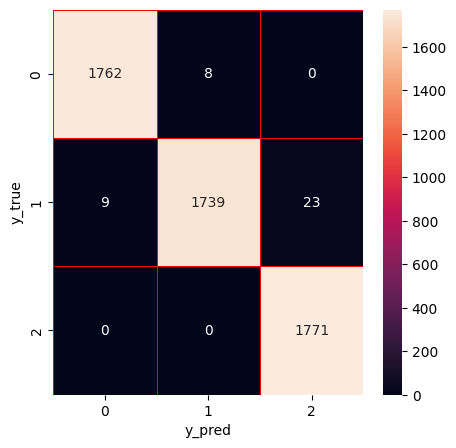

In [42]:
cm_log=confusion_matrix(y_test,y_pred_log)
f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm_log,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Support Vector Machine

In [43]:
pipe_svc = make_pipeline(StandardScaler(),SVC(C=5,kernel='poly',gamma='auto'))
pipe_svc

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=5, gamma='auto', kernel='poly'))])

In [44]:
pipe_svc.get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('svc', SVC(C=5, gamma='auto', kernel='poly'))],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'svc': SVC(C=5, gamma='auto', kernel='poly'),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'svc__C': 5,
 'svc__break_ties': False,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': 'ovr',
 'svc__degree': 3,
 'svc__gamma': 'auto',
 'svc__kernel': 'poly',
 'svc__max_iter': -1,
 'svc__probability': False,
 'svc__random_state': None,
 'svc__shrinking': True,
 'svc__tol': 0.001,
 'svc__verbose': False}

In [45]:
pipe_svc.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=5, gamma='auto', kernel='poly'))])

In [46]:
y_svc_pred=pipe_svc.predict(X_test)

In [47]:
print(classification_report(y_test,y_svc_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1770
           1       1.00      0.99      0.99      1771
           2       0.99      1.00      0.99      1771

    accuracy                           0.99      5312
   macro avg       0.99      0.99      0.99      5312
weighted avg       0.99      0.99      0.99      5312



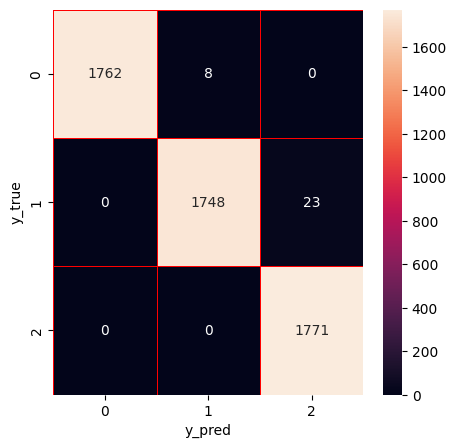

In [48]:
cm_svc=confusion_matrix(y_test,y_svc_pred)
f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm_svc,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

XGBoost

In [49]:
param_grid_xgboost = {
    "xgbclassifier__max_depth": [3, 4, 5, 7],
    "xgbclassifier__learning_rate": [0.1, 0.01, 0.05],
    "xgbclassifier__gamma": [0, 0.25, 1],
    "xgbclassifier__reg_lambda": [0, 1, 10],
    "xgbclassifier__scale_pos_weight": [1, 3, 5],
    "xgbclassifier__subsample": [0.8],
    "xgbclassifier__colsample_bytree": [0.5],
}

In [50]:
pipe_xgboost = make_pipeline(StandardScaler(),XGBClassifier())

In [51]:
pipe_xgboost.get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('xgbclassifier',
   XGBClassifier(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=None, device=None, early_stopping_rounds=None,
                 enable_categorical=False, eval_metric=None, feature_types=None,
                 gamma=None, grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=None, max_bin=None,
                 max_cat_threshold=None, max_cat_to_onehot=None,
                 max_delta_step=None, max_depth=None, max_leaves=None,
                 min_child_weight=None, missing=nan, monotone_constraints=None,
                 multi_strategy=None, n_estimators=None, n_jobs=None,
                 num_parallel_tree=None, random_state=None, ...))],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'xgbclassifier': XGBClassifier(base_score=None, booster=None, c

In [52]:
gs_xg = GridSearchCV(pipe_xgboost,param_grid=param_grid_xgboost,n_jobs=-1,cv=5)
gs_xg.fit(X_train,y_train)
print(gs_xg.best_estimator_)
print(gs_xg.best_score_)

f:\Zaidan codes\Weather Station New\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [20:23:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.5, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy

In [53]:
gs_xg.best_params_

{'xgbclassifier__colsample_bytree': 0.5,
 'xgbclassifier__gamma': 0,
 'xgbclassifier__learning_rate': 0.1,
 'xgbclassifier__max_depth': 7,
 'xgbclassifier__reg_lambda': 1,
 'xgbclassifier__scale_pos_weight': 1,
 'xgbclassifier__subsample': 0.8}

In [54]:
y_pred_xgbclas = gs_xg.predict(X_test)
print(classification_report(y_test,y_pred_xgbclas))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1770
           1       1.00      1.00      1.00      1771
           2       1.00      1.00      1.00      1771

    accuracy                           1.00      5312
   macro avg       1.00      1.00      1.00      5312
weighted avg       1.00      1.00      1.00      5312



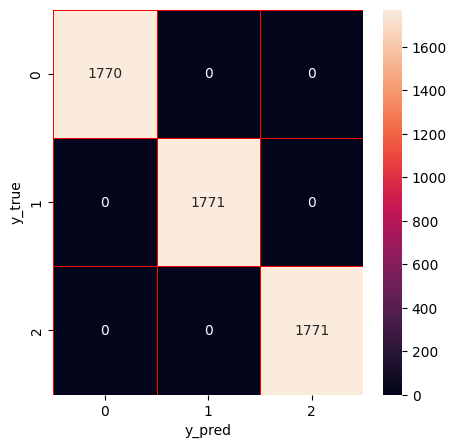

In [55]:
cm_xg=confusion_matrix(y_test,y_pred_xgbclas)
f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm_xg,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Artificial Neural Network (ANN)

In [61]:
import tensorflow
from keras.models import Sequential
from keras.layers import Dense,Dropout

classifier = Sequential()
classifier.add(Dense(32,input_shape=(len(X.columns),),activation='relu'))
classifier.add(Dropout(0.2))
classifier.add(Dense(64, activation='relu'))
classifier.add(Dropout(0.2))
classifier.add(Dense(3,activation='softmax'))
classifier.compile(loss='sparse_categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

classifier.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                160       
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 3)                 195       
                                                                 
Total params: 2467 (9.64 KB)
Trainable params: 2467 (9.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [62]:
classifier.fit(X_train,y_train,epochs=20, validation_data=(X_test,y_test))

Epoch 1/20
664/664 [==============================] - 4s 4ms/step - loss: 1.8654 - accuracy: 0.6753 - val_loss: 0.3430 - val_accuracy: 0.8285
Epoch 2/20
664/664 [==============================] - 3s 4ms/step - loss: 0.3833 - accuracy: 0.8262 - val_loss: 0.2492 - val_accuracy: 0.8682
Epoch 3/20
664/664 [==============================] - 2s 4ms/step - loss: 0.2528 - accuracy: 0.8932 - val_loss: 0.1196 - val_accuracy: 0.9776
Epoch 4/20
664/664 [==============================] - 2s 3ms/step - loss: 0.1660 - accuracy: 0.9347 - val_loss: 0.0633 - val_accuracy: 0.9853
Epoch 5/20
664/664 [==============================] - 2s 4ms/step - loss: 0.1230 - accuracy: 0.9509 - val_loss: 0.0388 - val_accuracy: 0.9906
Epoch 6/20
664/664 [==============================] - 3s 4ms/step - loss: 0.0878 - accuracy: 0.9671 - val_loss: 0.0296 - val_accuracy: 0.9940
Epoch 7/20
664/664 [==============================] - 2s 4ms/step - loss: 0.0659 - accuracy: 0.9754 - val_loss: 0.0227 - val_accuracy: 0.9940
Epoch 

In [63]:
classifier.evaluate(X_test,y_test)

166/166 [==============================] - 0s 2ms/step - loss: 0.0090 - accuracy: 0.9985


[0.008957821875810623, 0.9984939694404602]

In [64]:
y_ANN_predict = classifier.predict(X_test)

166/166 [==============================] - 0s 1ms/step


In [65]:
print(classification_report(y_test,y_ANN_predict.argmax(axis=1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1770
           1       1.00      1.00      1.00      1771
           2       1.00      1.00      1.00      1771

    accuracy                           1.00      5312
   macro avg       1.00      1.00      1.00      5312
weighted avg       1.00      1.00      1.00      5312



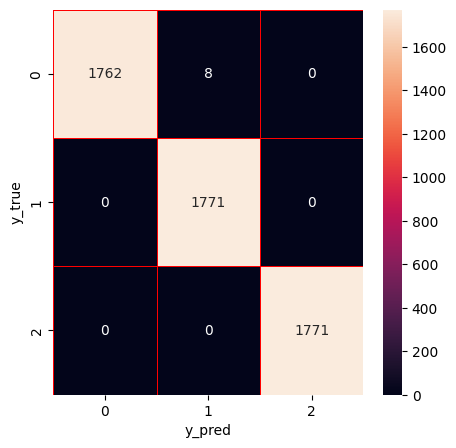

In [66]:
cm_ANN=confusion_matrix(y_test,y_ANN_predict.argmax(axis=1))
f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm_ANN,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()